# 报告项目

In [156]:
# 原始数据处理
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from time import time
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import fbeta_score, accuracy_score

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
import visuals as vs
import zipfile, os
from IPython.display import display # 使得我们可以对DataFrame使用display()函数

# 设置以内联的形式显示matplotlib绘制的图片（在notebook中显示更美观）
%matplotlib inline
    

# 载入整个客户数据集
data = pd.read_csv("train.csv")
#data["StateHoliday"] = data["StateHoliday"].replace(["0","a","b","c"],[0,1,2,3])
#data["StateHoliday"] = data["StateHoliday"].replace(["0","a","b","c"],[0,1,2,3])
data["StateHoliday"] = data["StateHoliday"].replace(["0"],[0])
data = pd.get_dummies(data,columns=['StateHoliday'])
#print data


print "总条数:"+str(len(data))
#data = data[data['Sales'] >0]
#print "去除0的条数:"+str(len(data))


prices = data['Sales']

#prices = data['Sales']
#features = data.drop(['Sales','Date','Customers'], axis = 1)

# TODO: Minimum price of the data
#目标：计算价值的最小值
minimum_price = np.min(prices)

# TODO: Maximum price of the data
#目标：计算价值的最大值
maximum_price = np.max(prices)

# TODO: Mean price of the data
#目标：计算价值的平均值
mean_price = np.mean(prices)

# TODO: Median price of the data
#目标：计算价值的中值
median_price = np.median(prices)

# TODO: Standard deviation of prices of the data
#目标：计算价值的标准差
std_price = np.std(prices)

# Show the calculated statistics
#目标：输出计算的结果
print "Sales最小值: {:,.2f}".format(minimum_price)
print "Sales最大值: {:,.2f}".format(maximum_price)
print "Sales均值: {:,.2f}".format(mean_price)
print "Sales中值 {:,.2f}".format(median_price)
print "Sales标准差: {:,.2f}".format(std_price)

ktest = pd.read_csv("test.csv")
#ktest["StateHoliday"] = ktest["StateHoliday"].replace(["0","a","b","c"],[0,1,2,3])
ktest = pd.get_dummies(ktest,columns=['StateHoliday'])

总条数:1017209
Sales最小值: 0.00
Sales最大值: 41,551.00
Sales均值: 5,773.82
Sales中值 5,744.00
Sales标准差: 3,849.92


In [19]:
#合并数据
store = pd.read_csv("store.csv")
#store["StoreType"] = store["StoreType"].replace(["a","b","c","d"],[1,2,3,4])
#store["Assortment"] = store["Assortment"].replace(["a","b","c"],[1,2,3])
store = pd.get_dummies(store,columns=['StoreType','Assortment'])
#store_dic = dict(list(store.groupby('Store')))

#print features["Store"]

def tof2(pb):
    npb = pb.copy()
    
    ss = dict()
    for s in store:
        #print s
        if s!="Store":
            #print s
            ss[s]=[]     

    #print ss
    #print npb
    #print len(npb)
    #print "change date"
    npb['Year']  = npb['Date'].apply(lambda x: int(str(x)[:4]))
    npb['Month'] = npb['Date'].apply(lambda x: int(str(x)[5:7]))
    
    #print "change merge"
    npb = pd.merge(npb, store, on='Store')

    """
    for i in range(0,npb.shape[0]):
        #print i
        #print npb['Date'][:4]

        #npb["StateHoliday"] = npb["StateHoliday"].replace(["a","b","c"],[1,2,3])
        s = store_dic[npb["Store"][i]]
        for sc in ss:
            #sc = str(sc)
            #print sc+" "+str(s[sc].values[0])
            #print s[sc]
            #ss["StoreType"].append(s[sc].values[0])
            ss[sc].append(s[sc].values[0])
            #print ss[sc].values
        #    print sc
            #print sc
    for sc in ss:
        npb[sc]=ss[sc]
    """
    
    npb = npb.drop(['PromoInterval'], axis = 1)
    
    return npb

#print store.head(1)
#print ktest.head(1)
testdata = tof2(data)

print "完成合并数据"
#print testdata.head(1)
#testdata["StateHoliday"] = testdata["StateHoliday"].replace(["a","b","c"],[1,2,3])

完成合并数据


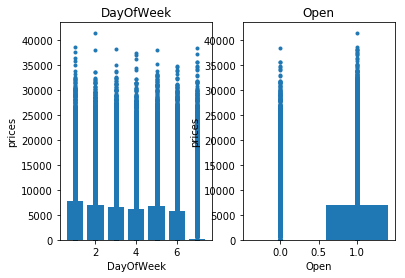

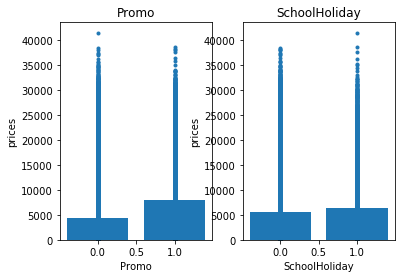

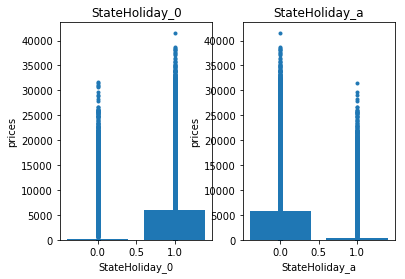

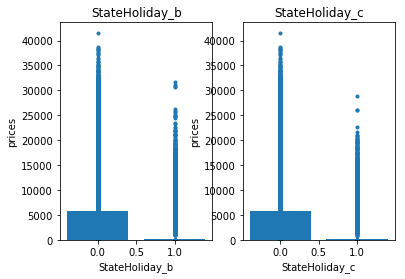

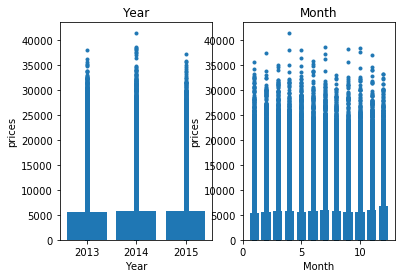

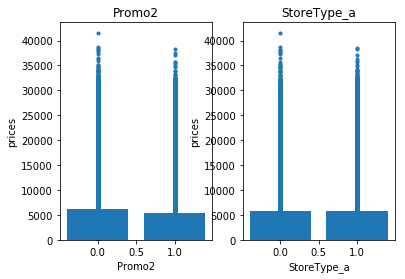

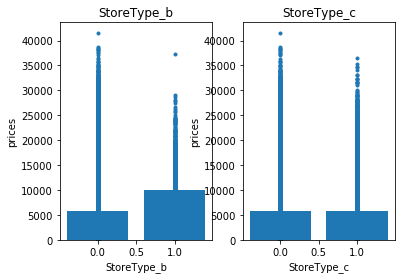

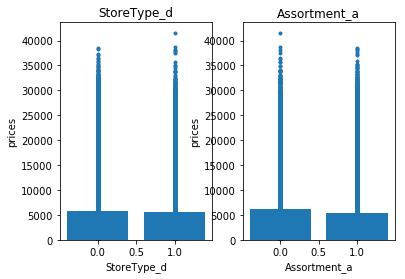

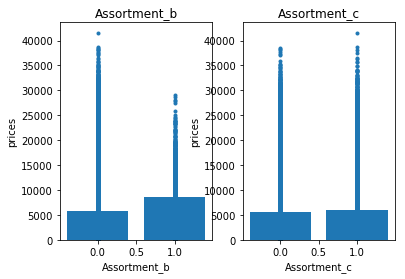

In [20]:
import matplotlib.pyplot as plt

features = testdata.drop(['Store','Sales','Date','Customers','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek','CompetitionDistance'], axis = 1)

for i,col in enumerate(features.columns):
    plt.subplot(1,2,(i%2+1))
    #print col
    g = testdata.groupby(col)["Sales"].mean()
    #print g
    
    #plt.plot(features[col],prices,'.')

    plt.bar(g.index,g.values)    
    plt.plot(testdata[col],prices,'.')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')
    
    if (i+1)%2 == 0: 
        plt.show()
        
plt.show()



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123fff2d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x21b10bb50>]], dtype=object)

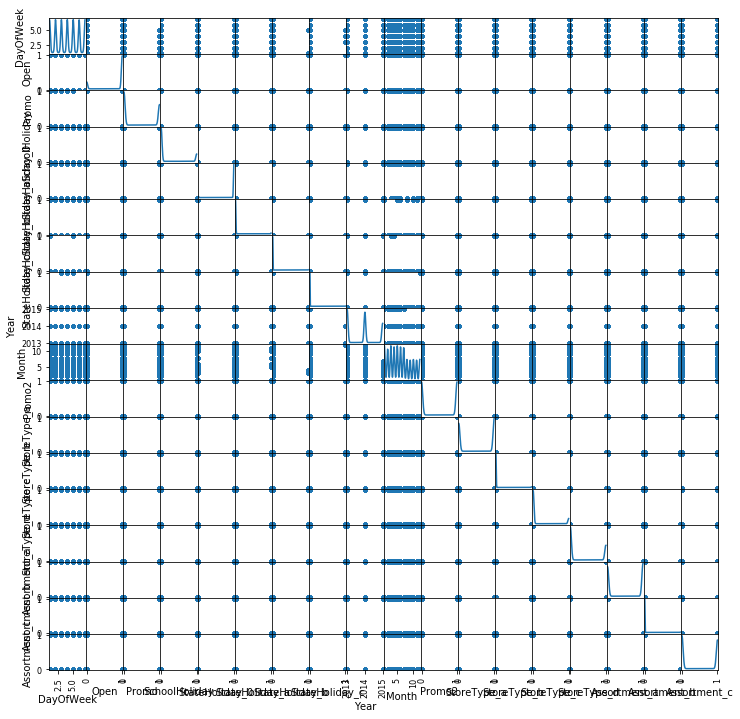

In [119]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(features, alpha=0.2, figsize=(12, 12), diagonal='kde')

In [57]:
#拆分数据
X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=0)

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def RMSPE(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def outcvszip(clf,num,x_test=X_test,ktestdata=testdata,Y_test=y_test):
    name = clf.__class__.__name__+"_"+str(num)
    y_pred = clf.predict(x_test)
    print name+" 的RMSPE得分:"+str(RMSPE(Y_test, y_pred))
    
    predictions_test = clf.predict(ktestdata)
    d = {'Id':pd.Series(range(1,len(predictions_test)+1),index=range(1,len(predictions_test)+1)),'Sales':pd.Series(predictions_test,index=range(1,len(predictions_test)+1))}
    df = pd.DataFrame(d)
                                                                                                          
    #print predictions_test
    #print df
    csvname = name+"_v4.csv"
    df.to_csv(csvname,index=False)#header=False
    
    zipFile = zipfile.ZipFile(name+'_v4.zip', 'w')
    zipFile.write(csvname, compress_type=zipfile.ZIP_DEFLATED)
    zipFile.close()
    #print str(y_test[0])+" "+ str(predictions_test[0])
    print name+"写入文件完成"

#'Store',
#features = testdata.drop(['Sales','Date','Customers','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek','CompetitionDistance'], axis = 1)

#X_train, X_test, y_train, y_test = train_test_split( features, prices, test_size=0.2, random_state=0)

In [54]:
def testpredict(dic,X):
    predictions_test = []
    for s in X["Store"]:
        predictions_test.append(dic[s])
    return np.array(predictions_test)

def test(dic,name):
    
    X_train, X_test, y_train, y_test = train_test_split( data, prices, test_size=0.2, random_state=0)
    
    predictions_test = testpredict(dic,X_test)
    print name+" 的本地RMSPE得分:"+str(RMSPE(y_test, predictions_test))
    
    predictions_test = testpredict(dic,ktest)
        
    d = {'Id':pd.Series(range(1,len(predictions_test)+1),index=range(1,len(predictions_test)+1)),'Sales':pd.Series(predictions_test,index=range(1,len(predictions_test)+1))}
    df = pd.DataFrame(d)
                                                                                                          
    #print predictions_test
    #print df
    csvname = name+"_v4.csv"
    df.to_csv(csvname,index=False)#header=False
    
    zipFile = zipfile.ZipFile(name+'_v4.zip', 'w')
    zipFile.write(csvname, compress_type=zipfile.ZIP_DEFLATED)
    zipFile.close()
    #print str(y_test[0])+" "+ str(predictions_test[0])
    print name+"写入文件完成"
    


meandic = data.groupby("Store")["Sales"].mean()
mediandic =  data.groupby("Store")["Sales"].median()

test(meandic,"mean")
test(mediandic,"median")
 
#print meandic[2]

mean 的本地RMSPE得分:0.547185081047
mean写入文件完成
median 的本地RMSPE得分:0.516694408912
median写入文件完成


In [135]:
clfs = []
#clfs.append(tree.DecisionTreeClassifier(random_state = 0))
clfs.append(tree.DecisionTreeRegressor(random_state = 0))
clfs.append(RandomForestRegressor(random_state=0))

num=features.shape[0]
for clf in clfs:
    start = time()
    #clf.fit(features.head(n=20000),prices.head(n=20000))
    #clf = clf.fit(features.head(n=num),prices.head(n=num))
    clf = clf.fit(X_train,y_train)
    end = time()
    print clf.__class__.__name__+"使用训练数量:"+str(num)+" 用时:"+str(end-start)

DecisionTreeRegressor使用训练数量:1017209 用时:2.64048290253
RandomForestRegressor使用训练数量:1017209 用时:19.3585779667


In [59]:
testdata1 =  tof2(ktest)

testdata1['StateHoliday_b']  = testdata1['Date'].apply(lambda x: 0)
testdata1['StateHoliday_c']  = testdata1['Date'].apply(lambda x: 0)

testdata1 = testdata1.drop(['Id','Store','Date','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek','CompetitionDistance'], axis = 1)

#testdata1 = testdata1.reindex_axis(sorted(testdata1.columns), axis=1)

#print features.head(1)
#print testdata1.head(1)
#X_train, X_test, y_train, y_test = train_test_split(features, prices, test_size=0.2, random_state=0)

for clf in clfs:
    outcvszip(clf,"1",x_test=X_test,ktestdata=testdata1)

DecisionTreeRegressor_1 的RMSPE得分:0.680670811749
DecisionTreeRegressor_1写入文件完成
RandomForestRegressor_1 的RMSPE得分:0.69064781293
RandomForestRegressor_1写入文件完成


In [81]:
def performance_metric(y_true, y_predict):
    score = RMSPE(y_true,y_predict) 
    # Return the score
    return score

scoring_fnc = make_scorer(performance_metric,greater_is_better=False)

#X_train, X_test, y_train, y_test = train_test_split( features, prices, test_size=0.2, random_state=0)
#X_train2, X_test2, y_train2, y_test2 = train_test_split( features, prices, test_size=0.2, random_state=1)

params = []
#params.append({'fit_intercept':[True,False],'normalize':[True,False],'copy_X':[True,False],'n_jobs':[-1]})
params.append({'min_samples_split':[100,500,1000,2000],'min_samples_leaf':[100,500,1000,2000],'random_state':[0]})#,'presort':[True,False]
params.append({'n_jobs':[-1],'min_samples_split':[1000,2000],'min_samples_leaf':[1000,2000],'random_state':[0]})#,'max_depth':[None,1,3,5]

oclfs = []

for i in range(0,len(clfs)):
    #X_train, X_test, y_train, y_test
    clf = clfs[i]
    p = params[i]
    name = clf.__class__.__name__
    
    #if name== 'RandomForestRegressor':
    start = time()
    grid =  GridSearchCV(clf, p, scoring_fnc, cv=5,n_jobs=-1) 
    grid = grid.fit(X_train, y_train)   
    oclf = grid.best_estimator_    
    oclfs.append(oclf)
    
    y_pred = oclf.predict(X_test)
    
    end = time()
    print name+" 优化后的RMSPE得分:"+str(RMSPE(y_test, y_pred))+" 用时:"+str(end-start)

#LinearRegression 优化后的RMSPE得分:0.551933640687 用时:24.5874650478
#DecisionTreeRegressor 优化后的RMSPE得分:1.31691570329 用时:651.78999114

DecisionTreeRegressor 优化后的RMSPE得分:0.942851191259 用时:129.831663847
RandomForestRegressor 优化后的RMSPE得分:0.668315624851 用时:200.163137913


In [82]:
#第2次训练
for clf in oclfs:
    #X_train, X_test, y_train, y_test
    outcvszip(clf,"2",x_test=X_test,ktestdata=testdata1)
    #outcvszip(clf,2)

DecisionTreeRegressor_2 的RMSPE得分:0.942851191259
DecisionTreeRegressor_2写入文件完成
RandomForestRegressor_2 的RMSPE得分:0.668315624851
RandomForestRegressor_2写入文件完成


In [83]:
#3-σ去除异常数据
#data["StateHoliday"] = data["StateHoliday"].replace(["0","a","b","c"],[0,1,2,3])

ndata = testdata.copy()
#features2 = ndata.drop(['Store','Sales','Date','Customers','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek','CompetitionDistance'], axis = 1)
f3 = ndata.drop(['Store','Date','Customers','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek','CompetitionDistance'], axis = 1)
#'Sales',
#print "总条数:"+str(len(data))
#data = data[data['Sales'] >0]
#print "去除0的条数:"+str(len(data))
#prices = data['Sales']

#f4 = f3[f3.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

f3['isOk']  = f3['Sales'].apply(lambda x: np.abs(x - mean_price) / std_price < 3)
f4 = f3[f3['isOk'] == True]

prices5 = f4['Sales']
f5 = f4.drop(['Sales','isOk'], axis = 1)

#X_train, X_test, y_train, y_test = train_test_split( features, prices, test_size=0.2, random_state=0)

print features.shape
print f5.shape


(1017209, 18)
(1007478, 18)


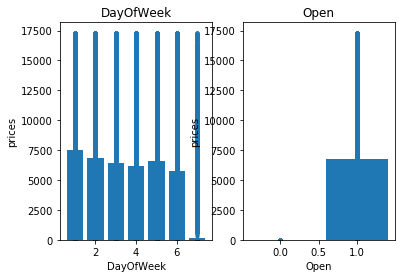

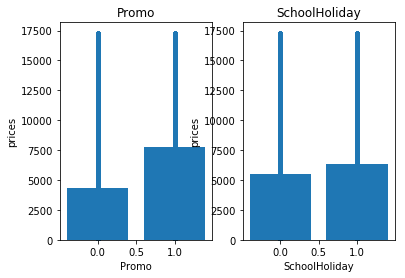

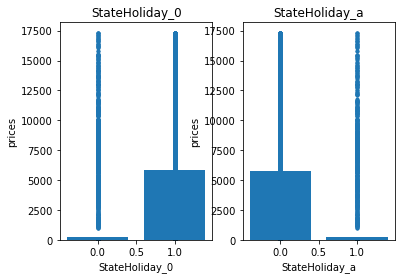

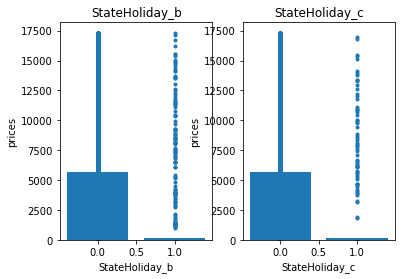

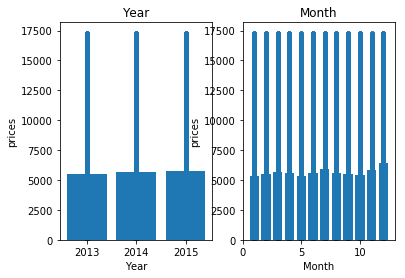

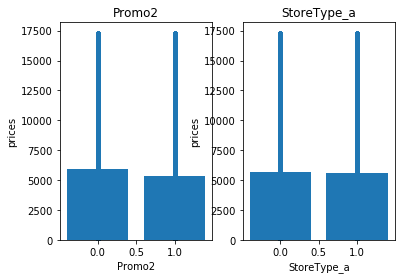

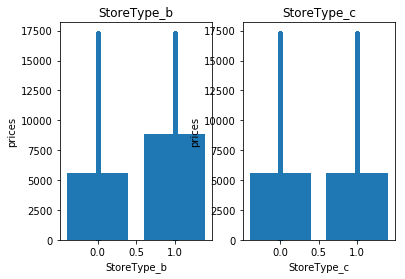

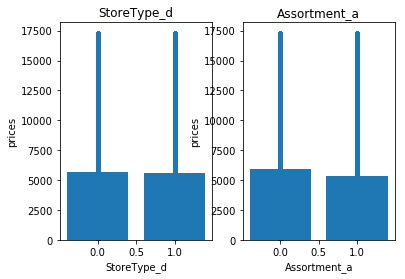

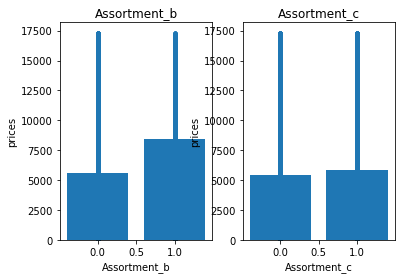

In [71]:
for i,col in enumerate(f5.columns):
    plt.subplot(1,2,(i%2+1))
    #print col
    g = f4.groupby(col)["Sales"].mean()
    #print g
    
    #plt.plot(features[col],prices,'.')

    plt.bar(g.index,g.values)
    plt.plot(f5[col],prices5,'.')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')
3    
    if (i+1)%2 == 0: 
        plt.show()
        
plt.show()


In [72]:
#第三次训练

X_train5, X_test5, y_train5, y_test5 = train_test_split( f5, prices5, test_size=0.2, random_state=0)

num=f5.shape[0]
for clf in clfs:
    start = time()
    #clf.fit(features.head(n=20000),prices.head(n=20000))
    #clf = clf.fit(features.head(n=num),prices.head(n=num))
    clf = clf.fit(X_train5,y_train5)
    end = time()
    print clf.__class__.__name__+"使用训练数量:"+str(num)+" 用时:"+str(end-start)

DecisionTreeRegressor使用训练数量:1007478 用时:2.77217698097
RandomForestRegressor使用训练数量:1007478 用时:16.4136381149


In [141]:
for clf in clfs:
    outcvszip(clf,"3",x_test=X_test,ktestdata=testdata1,Y_test=y_test)

DecisionTreeRegressor_3 的RMSPE得分:0.848660136252
DecisionTreeRegressor_3写入文件完成
RandomForestRegressor_3 的RMSPE得分:0.828673798383
RandomForestRegressor_3写入文件完成


In [142]:
#第4次训练
def performance_metric(y_true, y_predict):
    score = RMSPE(y_true,y_predict) 
    # Return the score
    return score

scoring_fnc = make_scorer(performance_metric,greater_is_better=False)

#X_train, X_test, y_train, y_test = train_test_split( features, prices, test_size=0.2, random_state=0)
#X_train2, X_test2, y_train2, y_test2 = train_test_split( features, prices, test_size=0.2, random_state=1)

params = []
#params.append({'fit_intercept':[True,False],'normalize':[True,False],'copy_X':[True,False],'n_jobs':[-1]})
params.append({'min_samples_split':[100,500,1000,2000],'min_samples_leaf':[100,500,1000,2000],'random_state':[0]})#,'presort':[True,False]
params.append({'n_jobs':[-1],'min_samples_split':[1000,2000],'min_samples_leaf':[1000,2000],'random_state':[0]})#,'max_depth':[None,1,3,5]

oclfs = []

for i in range(0,len(clfs)):
    #X_train, X_test, y_train, y_test
    clf = clfs[i]
    p = params[i]
    name = clf.__class__.__name__
    
    #if name== 'RandomForestRegressor':
    start = time()
    grid =  GridSearchCV(clf, p, scoring_fnc, cv=5,n_jobs=-1) 
    grid = grid.fit(X_train5, y_train5)   
    oclf = grid.best_estimator_    
    oclfs.append(oclf)
    
    y_pred = oclf.predict(X_test)
    
    end = time()
    print name+" 优化后的RMSPE得分:"+str(RMSPE(y_test, y_pred))+" 用时:"+str(end-start)

DecisionTreeRegressor 优化后的RMSPE得分:0.589316895248 用时:123.10774684
RandomForestRegressor 优化后的RMSPE得分:0.580364484505 用时:170.842386961


In [143]:
#第4次训练
for clf in oclfs:
    #X_train, X_test, y_train, y_test
    outcvszip(clf,"4",x_test=X_test,ktestdata=testdata1,Y_test=y_test)
    #outcvszip(clf,2)

DecisionTreeRegressor_4 的RMSPE得分:0.589316895248
DecisionTreeRegressor_4写入文件完成
RandomForestRegressor_4 的RMSPE得分:0.580364484505
RandomForestRegressor_4写入文件完成


In [97]:
#3-σ去除异常数据
#data["StateHoliday"] = data["StateHoliday"].replace(["0","a","b","c"],[0,1,2,3])

ndata = testdata.copy()
#features2 = ndata.drop(['Store','Sales','Date','Customers','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek','CompetitionDistance'], axis = 1)
f6 = ndata.drop(['Store','Date','Customers','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek','CompetitionDistance'], axis = 1)
#'Sales',
#print "总条数:"+str(len(data))
#data = data[data['Sales'] >0]
#print "去除0的条数:"+str(len(data))
#prices = data['Sales']

#f4 = f3[f3.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
for col in f6.columns:
    if (col != "Sales"):
        #print col
        ms = f6.groupby(col)["Sales"].mean()
        ss = f6.groupby(col)["Sales"].std()
        for i in range(len(ms)):  
            m = ms.values[i]
            s = ss.values[i]
            #print col+"=="+str(ms.index[i])
            #print "mean:"+str(m)+" std:"+str(s)
            #print f6.shape
            #    npb['Year']  = npb['Date'].apply(lambda x: int(str(x)[:4]))
            f6['isOk']  = f6[f6[col]==ms.index[i]]['Sales'].apply(lambda x: np.abs(x - m) / s < 3)
            f6 = f6[f6['isOk'] != False]
            f6 = f6.drop(['isOk'], axis = 1)
            print f6.shape
            print "----------"


#f6['isOk']  = f6['Sales'].apply(lambda x: np.abs(x - mean_price) / std_price < 3)
#f7 = f6[f6['isOk'] == True]

prices7 = f6['Sales']
f7 = f6.drop(['Sales'], axis = 1)

#X_train, X_test, y_train, y_test = train_test_split( features, prices, test_size=0.2, random_state=0)

print features.shape
print f7.shape


DayOfWeek==1
(1017209, 19)
(1015557, 19)
----------
DayOfWeek==2
(1015557, 19)
(1013333, 19)
----------
DayOfWeek==3
(1013333, 19)
(1011260, 19)
----------
DayOfWeek==4
(1011260, 19)
(1009573, 19)
----------
DayOfWeek==5
(1009573, 19)
(1007768, 19)
----------
DayOfWeek==6
(1007768, 19)
(1005523, 19)
----------
DayOfWeek==7
(1005523, 19)
(1003243, 19)
----------
Open==0
(1003243, 19)
(830426, 19)
----------
Open==1
(830426, 19)
(822022, 19)
----------
Promo==0
(822022, 19)
(816261, 19)
----------
Promo==1
(816261, 19)
(816238, 19)
----------
SchoolHoliday==0
(816238, 19)
(812430, 19)
----------
SchoolHoliday==1
(812430, 19)
(811757, 19)
----------
StateHoliday_0==0
(811757, 19)
(811757, 19)
----------
StateHoliday_0==1
(811757, 19)
(810175, 19)
----------
StateHoliday_a==0
(810175, 19)
(809679, 19)
----------
StateHoliday_a==1
(809679, 19)
(809679, 19)
----------
StateHoliday_b==0
(809679, 19)
(809524, 19)
----------
StateHoliday_b==1
(809524, 19)
(809524, 19)
----------
StateHoliday_c=

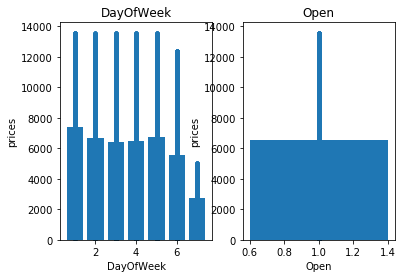

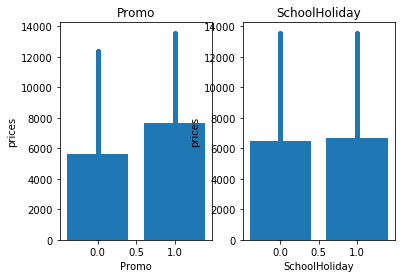

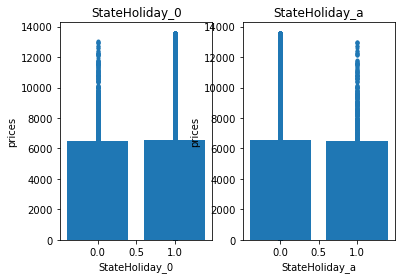

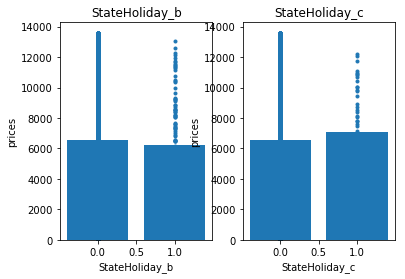

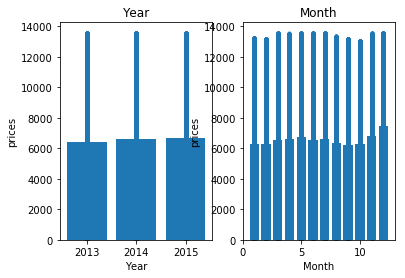

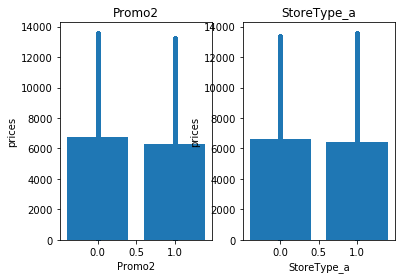

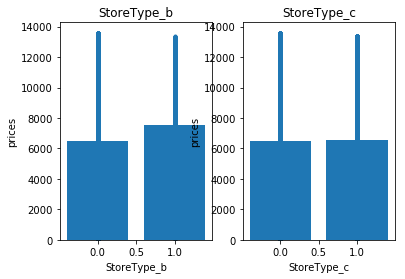

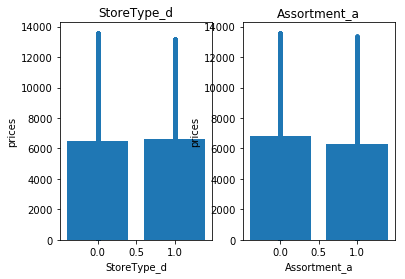

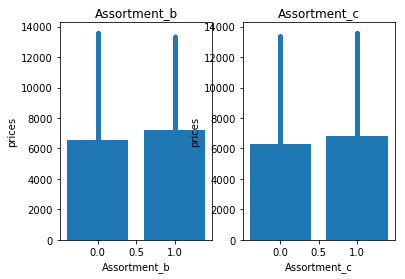

In [99]:
for i,col in enumerate(f7.columns):
    plt.subplot(1,2,(i%2+1))
    #print col
    g = f6.groupby(col)["Sales"].mean()
    #print g
    
    #plt.plot(features[col],prices,'.')

    plt.bar(g.index,g.values)
    plt.plot(f7[col],prices7,'.')

    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')
    
    if (i+1)%2 == 0: 
        plt.show()
        
plt.show()

In [100]:
#第5次训练
X_train7, X_test7, y_train7, y_test7 = train_test_split( f7, prices7, test_size=0.2, random_state=0)

num=f7.shape[0]
for clf in clfs:
    start = time()
    #clf.fit(features.head(n=20000),prices.head(n=20000))
    #clf = clf.fit(features.head(n=num),prices.head(n=num))
    clf = clf.fit(X_train7,y_train7)
    end = time()
    print clf.__class__.__name__+"使用训练数量:"+str(num)+" 用时:"+str(end-start)

DecisionTreeRegressor使用训练数量:805700 用时:1.90441298485
RandomForestRegressor使用训练数量:805700 用时:14.5435271263


In [145]:
for clf in clfs:
    outcvszip(clf,"5",x_test=X_test,ktestdata=testdata1,Y_test=y_test)

DecisionTreeRegressor_5 的RMSPE得分:0.848660136252
DecisionTreeRegressor_5写入文件完成
RandomForestRegressor_5 的RMSPE得分:0.828673798383
RandomForestRegressor_5写入文件完成


In [182]:
#第6次训练
def performance_metric(y_true, y_predict):
    score = RMSPE(y_true,y_predict) 
    # Return the score
    return score

scoring_fnc = make_scorer(performance_metric,greater_is_better=False)

#X_train, X_test, y_train, y_test = train_test_split( features, prices, test_size=0.2, random_state=0)
#X_train2, X_test2, y_train2, y_test2 = train_test_split( features, prices, test_size=0.2, random_state=1)

params = []
#params.append({'fit_intercept':[True,False],'normalize':[True,False],'copy_X':[True,False],'n_jobs':[-1]})
params.append({'min_samples_split':[100,500,1000,2000],'min_samples_leaf':[100,500,1000,2000],'random_state':[0]})#,'presort':[True,False]
params.append({'n_jobs':[-1],'min_samples_split':[1000,2000],'min_samples_leaf':[1000,2000],'random_state':[0]})#,'max_depth':[None,1,3,5]

oclfs = []

for i in range(0,len(clfs)):
    #X_train, X_test, y_train, y_test
    clf = clfs[i]
    p = params[i]
    name = clf.__class__.__name__
    
    #if name== 'RandomForestRegressor':
    start = time()
    grid =  GridSearchCV(clf, p, scoring_fnc, cv=5,n_jobs=-1) 
    grid = grid.fit(X_train7, y_train7)   
    oclf = grid.best_estimator_    
    oclfs.append(oclf)
    
    y_pred = oclf.predict(X_test7)
    
    end = time()
    print name+" 优化后的RMSPE得分:"+str(RMSPE(y_test7, y_pred))+" 用时:"+str(end-start)

DecisionTreeRegressor 优化后的RMSPE得分:0.314736740911 用时:108.628607035
RandomForestRegressor 优化后的RMSPE得分:0.318831997071 用时:130.336207867


In [146]:
#第6次训练
for clf in oclfs:
    #print oclfs
    #X_train, X_test, y_train, y_test
    outcvszip(clf,"6",x_test=X_test,ktestdata=testdata1,Y_test=y_test)
    #outcvszip(clf,2)

DecisionTreeRegressor_6 的RMSPE得分:0.589316895248
DecisionTreeRegressor_6写入文件完成
RandomForestRegressor_6 的RMSPE得分:0.580364484505
RandomForestRegressor_6写入文件完成


In [126]:
#3-σ去除异常数据
#data["StateHoliday"] = data["StateHoliday"].replace(["0","a","b","c"],[0,1,2,3])

ndata = testdata.copy()
#features2 = ndata.drop(['Store','Sales','Date','Customers','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek','CompetitionDistance'], axis = 1)
f8 = ndata.drop(['Date','Customers','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceYear','Promo2SinceWeek','CompetitionDistance'], axis = 1)
#'Sales',
#print "总条数:"+str(len(data))
#data = data[data['Sales'] >0]
#print "去除0的条数:"+str(len(data))
#prices = data['Sales']
#'Store',

#f4 = f3[f3.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
for col in ["Store"]:
        #print col
    ms = f8.groupby(col)["Sales"].mean()
    ss = f8.groupby(col)["Sales"].std()
    for i in range(len(ms)):  
        m = ms.values[i]
        s = ss.values[i]
            #print col+"=="+str(ms.index[i])
            #print "mean:"+str(m)+" std:"+str(s)
            #print f6.shape
            #    npb['Year']  = npb['Date'].apply(lambda x: int(str(x)[:4]))
        f8['isOk']  = f8[f8[col]==ms.index[i]]['Sales'].apply(lambda x: np.abs(x - m) / s < 3)
        f8 = f8[f8['isOk'] != False]
        f8 = f8.drop(['isOk'], axis = 1)
        #print f6.shape
        #print "----------"


#f6['isOk']  = f6['Sales'].apply(lambda x: np.abs(x - mean_price) / std_price < 3)
#f7 = f6[f6['isOk'] == True]

prices8 = f8['Sales']
f8 = f8.drop(['Store','Sales'], axis = 1)

#X_train, X_test, y_train, y_test = train_test_split( features, prices, test_size=0.2, random_state=0)

print features.shape
print f8.shape


(1017209, 18)
(1016042, 18)


In [162]:
#第7次训练
X_train8, X_test8, y_train8, y_test8 = train_test_split( f8, prices8, test_size=0.2, random_state=0)

num=f8.shape[0]

for clf in oclfs:
    start = time()
    #clf.fit(features.head(n=20000),prices.head(n=20000))
    #clf = clf.fit(features.head(n=num),prices.head(n=num))
    clf = clf.fit(X_train8,y_train8)
    end = time()
    print clf.__class__.__name__+"使用训练数量:"+str(num)+" 用时:"+str(end-start)

DecisionTreeRegressor使用训练数量:1016042 用时:2.48675608635
RandomForestRegressor使用训练数量:1016042 用时:10.330051899


In [163]:
#第7次训练
for clf in oclfs:
    #print oclfs
    #X_train, X_test, y_train, y_test
    outcvszip(clf,"7",x_test=X_test,ktestdata=testdata1,Y_test=y_test)
    #outcvszip(clf,2)

DecisionTreeRegressor_7 的RMSPE得分:0.587687144939
DecisionTreeRegressor_7写入文件完成
RandomForestRegressor_7 的RMSPE得分:0.578719567577
RandomForestRegressor_7写入文件完成


Feature ranking:
1. feature 2 DayOfWeek (0.643398)
2. feature 0 Open (0.128504)
3. feature 9 Promo (0.066494)
4. feature 15 SchoolHoliday (0.044121)
5. feature 10 StateHoliday_0 (0.033430)
6. feature 11 StateHoliday_a (0.025142)
7. feature 14 StateHoliday_b (0.016086)
8. feature 8 StateHoliday_c (0.014914)
9. feature 13 Year (0.012242)
10. feature 12 Month (0.006732)
11. feature 17 Promo2 (0.006195)
12. feature 3 StoreType_a (0.002743)
13. feature 16 StoreType_b (0.000000)
14. feature 7 StoreType_c (0.000000)
15. feature 6 StoreType_d (0.000000)
16. feature 5 Assortment_a (0.000000)
17. feature 4 Assortment_b (0.000000)
18. feature 1 Assortment_c (0.000000)


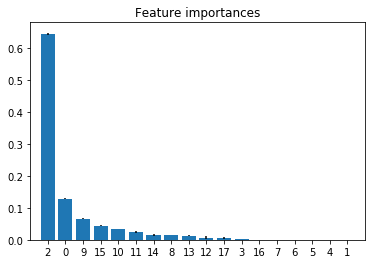

In [183]:
forest = oclfs[1]
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

#print forest
#print X_train.columns

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],X_train.columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [193]:
#第8次训练
f8 = data.copy()
f8 = data.drop(['Date','Customers','Sales'], axis = 1)

testdata8 = ktest.copy()
testdata8['StateHoliday_b']  = testdata8['Date'].apply(lambda x: 0)
testdata8['StateHoliday_c']  = testdata8['Date'].apply(lambda x: 0)
testdata8 = testdata8.drop(['Id','Date'], axis = 1)


#print f8.head(1)
#print testdata8.head(1)

X_train8, X_test8, y_train8, y_test8 = train_test_split( f8, prices, test_size=0.2, random_state=0)

num=f8.shape[0]

for clf in oclfs:
    start = time()
    #clf.fit(features.head(n=20000),prices.head(n=20000))
    #clf = clf.fit(features.head(n=num),prices.head(n=num))
    clf = clf.fit(X_train8,y_train8)
    end = time()
    print clf.__class__.__name__+"使用训练数量:"+str(num)+" 用时:"+str(end-start)

for clf in oclfs:
    #print oclfs
    #X_train, X_test, y_train, y_test
    outcvszip(clf,"8",x_test=X_test8,ktestdata=testdata8,Y_test=y_test)
    #outcvszip(clf,2)

DecisionTreeRegressor使用训练数量:1017209 用时:2.30653095245
RandomForestRegressor使用训练数量:1017209 用时:7.85849905014
DecisionTreeRegressor_8 的RMSPE得分:0.192174584985
DecisionTreeRegressor_8写入文件完成
RandomForestRegressor_8 的RMSPE得分:0.330593810724
RandomForestRegressor_8写入文件完成


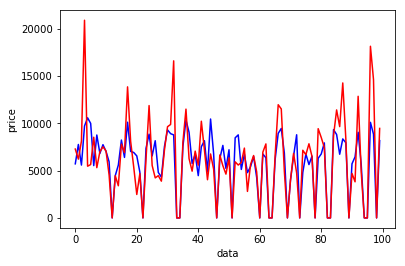

In [245]:
size=100
y_pred = oclf[0].predict(X_test8.head(size))
 
# Plot the results
#print y_pred.shape
#print y_pred
#print y_test8.head(10)
plt.plot(range(size), y_pred,color="blue")
plt.plot(range(size), y_test8.head(size),color="red")
plt.xlabel("data")
plt.ylabel("price")
plt.show()

